In [1]:
import os
import matplotlib
import torch
import datetime
import csv

import gymnasium as gym
import gymnasium.wrappers as gym_wrap
import matplotlib.pyplot as plt
import numpy as np
import DQN_model as DQN

from gymnasium.spaces import Box
from tensordict import TensorDict
from torch import nn
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

/Users/karthiksagar/anaconda3/lib/python3.11/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [2]:
from __future__ import annotations

import numpy as np

import gymnasium as gym
from gymnasium.error import DependencyNotInstalled
from gymnasium.spaces import Box


class ResizeObservation(gym.ObservationWrapper, gym.utils.RecordConstructorArgs):
    """Resize the image observation.

    This wrapper works on environments with image observations. More generally,
    the input can either be two-dimensional (AxB, e.g. grayscale images) or
    three-dimensional (AxBxC, e.g. color images). This resizes the observation
    to the shape given by the 2-tuple :attr:`shape`.
    The argument :attr:`shape` may also be an integer, in which case, the
    observation is scaled to a square of side-length :attr:`shape`.

    Example:
        >>> import gymnasium as gym
        >>> from gymnasium.wrappers import ResizeObservation
        >>> env = gym.make("CarRacing-v2")
        >>> env.observation_space.shape
        (96, 96, 3)
        >>> env = ResizeObservation(env, 64)
        >>> env.observation_space.shape
        (64, 64, 3)
    """

    def __init__(self, env: gym.Env, shape: tuple[int, int] | int) -> None:
        """Resizes image observations to shape given by :attr:`shape`.

        Args:
            env: The environment to apply the wrapper
            shape: The shape of the resized observations
        """
        gym.utils.RecordConstructorArgs.__init__(self, shape=shape)
        gym.ObservationWrapper.__init__(self, env)

        if isinstance(shape, int):
            shape = (shape, shape)
        assert len(shape) == 2 and all(
            x > 0 for x in shape
        ), f"Expected shape to be a 2-tuple of positive integers, got: {shape}"

        self.shape = tuple(shape)

        assert isinstance(
            env.observation_space, Box
        ), f"Expected the observation space to be Box, actual type: {type(env.observation_space)}"
        dims = len(env.observation_space.shape)
        assert (
            dims == 2 or dims == 3
        ), f"Expected the observation space to have 2 or 3 dimensions, got: {dims}"

        obs_shape = self.shape + env.observation_space.shape[2:]
        self.observation_space = Box(low=0, high=255, shape=obs_shape, dtype=np.uint8)

    def observation(self, observation):
        """Updates the observations by resizing the observation to shape given by :attr:`shape`.

        Args:
            observation: The observation to reshape

        Returns:
            The reshaped observations

        Raises:
            DependencyNotInstalled: opencv-python is not installed
        """
        try:
            import cv2
        except ImportError as e:
            raise DependencyNotInstalled(
                "opencv (cv2) is not installed, run `pip install gymnasium[other]`"
            ) from e

        observation = cv2.resize(
            observation, self.shape[::-1], interpolation=cv2.INTER_AREA
        )
        return observation.reshape(self.observation_space.shape)
    
class DiscretizedActionWrapper(gym.ActionWrapper):
    def __init__(self, env):
        super().__init__(env)
        self.actions = [
            np.array([0.0, 0.0, 0.0]),  # do nothing
            np.array([-1.0, 0.0, 0.0]), # left
            np.array([1.0, 0.0, 0.0]),  # right
            np.array([0.0, 1.0, 0.0]),  # gas
            np.array([0.0, 0.0, 0.8])   # brake
        ]
        self.action_space = gym.spaces.Discrete(len(self.actions))

    def action(self, act_idx):
        return self.actions[act_idx]


## Train a model from scratch

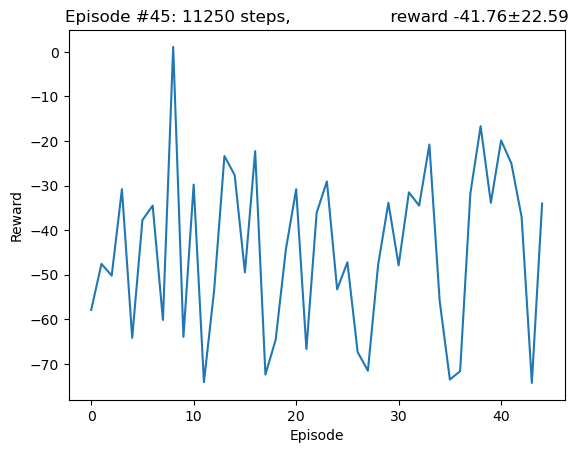

<Figure size 640x480 with 0 Axes>

In [ ]:
env = gym.make("CarRacing-v3", continuous=True, domain_randomize=False, render_mode="human")
env = DiscretizedActionWrapper(env)
env = DQN.SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = ResizeObservation(env, shape=84)
env = gym_wrap.FrameStackObservation(env, stack_size=4)
state, info = env.reset()
action_shape = env.action_space.shape[0] if isinstance(env.action_space, Box) else env.action_space.n
driver = DQN.Agent(state.shape, action_shape, double_q=True)
batch_n = 32
play_n_episodes = 3000
episode_epsilon_list = []
episode_reward_list = []
episode_length_list = []
episode_loss_list = []
episode_date_list = []
episode_time_list = []
episode = 0
timestep_n = 0
when2learn = 4 # in timesteps
when2sync = 5000 # in timesteps
when2save = 100000 # in timesteps
when2report = 5000 # in timesteps
when2eval = 50000 # in timesteps
when2log = 10 # in episodes
report_type = 'plot' # 'text', 'plot', None

while episode <= play_n_episodes:
    
    episode += 1
    episode_reward = 0
    episode_length = 0
    updating = True
    loss_list = []
    episode_epsilon_list.append(driver.epsilon)

    while updating:

        timestep_n += 1
        episode_length += 1
        
        action = driver.take_action(state)
        env.render()
        new_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        driver.store(state, action, reward, new_state, terminated)
        # Move to the next state
        state = new_state
        updating = not (terminated or truncated)

        if timestep_n % when2sync == 0:
            upd_net_param = driver.updating_net.state_dict()
            driver.frozen_net.load_state_dict(upd_net_param)
            
        if timestep_n % when2save == 0:
            driver.save(driver.save_dir, 'DQN')
            
        if timestep_n % when2learn == 0:
            q, loss = driver.update_net(batch_n)
            loss_list.append(loss)
        

        if timestep_n % when2report == 0 and report_type == 'text':
            print(f'Report: {timestep_n} timestep')
            print(f'    episodes: {episode}')
            print(f'    n_updates: {driver.n_updates}')
            print(f'    epsilon: {driver.epsilon}')

        if timestep_n % when2eval == 0 and report_type == 'text':
            rewards_tensor = torch.tensor(episode_reward_list,
                                          dtype=torch.float)
            eval_reward = torch.clone(rewards_tensor[-50:])
            mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
            std_eval_reward = round(torch.std(eval_reward).item(), 2)

            lengths_tensor = torch.tensor(episode_length_list,
                                          dtype=torch.float)
            eval_length = torch.clone(lengths_tensor[-50:])
            mean_eval_length = round(torch.mean(eval_length).item(), 2)
            std_eval_length = round(torch.std(eval_length).item(), 2)

            
            print(f'Evaluation: {timestep_n} timestep')
            print(f'    reward {mean_eval_reward}±{std_eval_reward}')
            print(f'    episode length {mean_eval_length}±{std_eval_length}')
            print(f'    episodes: {episode}')
            print(f'    n_updates: {driver.n_updates}')
            print(f'    epsilon: {driver.epsilon}')

    state, info = env.reset()
    
    episode_reward_list.append(episode_reward)
    episode_length_list.append(episode_length)
    episode_loss_list.append(np.mean(loss_list))
    now_time = datetime.datetime.now()
    episode_date_list.append(now_time.date().strftime('%Y-%m-%d'))
    episode_time_list.append(now_time.time().strftime('%H:%M:%S'))

    if report_type == 'plot':
        draw_check = DQN.plot_reward(episode, episode_reward_list, timestep_n)

    if episode % when2log == 0:
        driver.write_log(
            episode_date_list,
            episode_time_list,
            episode_reward_list,
            episode_length_list,
            episode_loss_list,
            episode_epsilon_list,
            log_filename='DQN_log_test.csv'
        )

if report_type == 'text':
    rewards_tensor = torch.tensor(episode_reward_list, dtype=torch.float)
    eval_reward = torch.clone(rewards_tensor[-100:])
    mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
    std_eval_reward = round(torch.std(eval_reward).item(), 2)

    lengths_tensor = torch.tensor(episode_length_list, dtype=torch.float)
    eval_length = torch.clone(lengths_tensor[-100:])
    mean_eval_length = round(torch.mean(eval_length).item(), 2)
    std_eval_length = round(torch.std(eval_length).item(), 2)
    
    print(f'Final evaluation: {timestep_n} timestep')
    print(f'    reward {mean_eval_reward}±{std_eval_reward}')
    print(f'    episode length {mean_eval_length}±{std_eval_length}')
    print(f'    episodes: {episode}')
    print(f'    n_updates: {driver.n_updates}')
    print(f'    epsilon: {driver.epsilon}')
    
driver.save(driver.save_dir, 'DQN')
driver.write_log(
    episode_date_list,
    episode_time_list,
    episode_reward_list,
    episode_length_list,
    episode_loss_list,
    episode_epsilon_list,
    log_filename='DQN_log_test.csv'
)

env.close()
plt.ioff()
plt.show()

## Continue training a loaded model

In [ ]:
env = gym.make("CarRacing-v2", continuous=False)
env = DQN.SkipFrame(env, skip=4)
env = gym_wrap.GrayscaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=84)
env = gym_wrap.FrameStackObservation(env, num_stack=4)
state, info = env.reset()
action_n = env.action_space.n
driver = DQN.Agent(state.shape, action_n,
               load_state='train', load_model='DDQN_741500.pt')
batch_n = 32
actions_taken = driver.act_taken
play_more_episodes = 5
episodes_played = 3000
timestep_n = 740188
episode = episodes_played
episode_epsilon_list = []
episode_reward_list = []
episode_length_list = []
episode_loss_list = []
episode_date_list = []
episode_time_list = []
when2learn = 4 # in timesteps
when2sync = 5000 # in timesteps
when2save = 100000 # in timesteps
when2report = 5000 # in timesteps
when2eval = 50000 # in timesteps
when2log = 10 # in episodes
report_type = 'plot' # 'text', 'plot', None
print(f'Initial exploration: {driver.epsilon}, Actions already taken: {actions_taken}, Episodes already played: {episode}')
while episode <= episodes_played + play_more_episodes:
    
    episode += 1
    episode_reward = 0
    episode_length = 0
    updating = True
    loss_list = []
    episode_epsilon_list.append(driver.epsilon)

    while updating:

        timestep_n += 1
        episode_length += 1
        
        action = driver.take_action(state)
        new_state, reward, terminated, truncated, info = env.step(action)
        episode_reward += reward
        driver.store(state, action, reward, new_state, terminated)
        # Move to the next state
        state = new_state
        updating = not (terminated or truncated)

        if timestep_n % when2sync == 0:
            upd_net_param = driver.updating_net.state_dict()
            driver.frozen_net.load_state_dict(upd_net_param)
            
        if timestep_n % when2save == 0:
            driver.save(driver.save_dir, 'DQN')
            
        if timestep_n % when2learn == 0:
            q, loss = driver.update_net(batch_n)
            loss_list.append(loss)
        

        if timestep_n % when2report == 0 and report_type == 'text':
            print(f'Report: {timestep_n} timestep')
            print(f'    episodes: {episode}')
            print(f'    n_updates: {driver.n_updates}')
            print(f'    epsilon: {driver.epsilon}')

        if timestep_n % when2eval == 0 and report_type == 'text':
            rewards_tensor = torch.tensor(episode_reward_list,
                                          dtype=torch.float)
            eval_reward = torch.clone(rewards_tensor[-50:])
            mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
            std_eval_reward = round(torch.std(eval_reward).item(), 2)

            lengths_tensor = torch.tensor(episode_length_list,
                                          dtype=torch.float)
            eval_length = torch.clone(lengths_tensor[-50:])
            mean_eval_length = round(torch.mean(eval_length).item(), 2)
            std_eval_length = round(torch.std(eval_length).item(), 2)

            
            print(f'Evaluation: {timestep_n} timestep')
            print(f'    reward {mean_eval_reward}±{std_eval_reward}')
            print(f'    episode length {mean_eval_length}±{std_eval_length}')
            print(f'    episodes: {episode}')
            print(f'    n_updates: {driver.n_updates}')
            print(f'    epsilon: {driver.epsilon}')

    state, info = env.reset()
    
    episode_reward_list.append(episode_reward)
    episode_length_list.append(episode_length)
    episode_loss_list.append(np.mean(loss_list))
    now_time = datetime.datetime.now()
    episode_date_list.append(now_time.date().strftime('%Y-%m-%d'))
    episode_time_list.append(now_time.time().strftime('%H:%M:%S'))
    
    if report_type == 'plot':
        draw_check = DQN.plot_reward(episode, episode_reward_list, timestep_n)

    if episode % when2log == 0:
        driver.write_log(
            episode_date_list,
            episode_time_list,
            episode_reward_list,
            episode_length_list,
            episode_loss_list,
            episode_epsilon_list,
            log_filename='DQN_log_test.csv'
            )

if report_type == 'text':
    rewards_tensor = torch.tensor(episode_reward_list, dtype=torch.float)
    eval_reward = torch.clone(rewards_tensor[-100:])
    mean_eval_reward = round(torch.mean(eval_reward).item(), 2)
    std_eval_reward = round(torch.std(eval_reward).item(), 2)

    lengths_tensor = torch.tensor(episode_length_list, dtype=torch.float)
    eval_length = torch.clone(lengths_tensor[-100:])
    mean_eval_length = round(torch.mean(eval_length).item(), 2)
    std_eval_length = round(torch.std(eval_length).item(), 2)
    
    print(f'Final evaluation: {timestep_n} timestep')
    print(f'    reward {mean_eval_reward}±{std_eval_reward}')
    print(f'    episode length {mean_eval_length}±{std_eval_length}')
    print(f'    episodes: {episode}')
    print(f'    n_updates: {driver.n_updates}')
    print(f'    epsilon: {driver.epsilon}')

driver.save(driver.save_dir, 'DQN')
driver.write_log(
    episode_date_list,
    episode_time_list,
    episode_reward_list,
    episode_length_list,
    episode_loss_list,
    episode_epsilon_list,
    log_filename='DQN_log_test.csv'
    )
env.close()
plt.ioff()
plt.show()

## Loaded model evaluation

In [ ]:
env = gym.make("CarRacing-v2", continuous=False, render_mode="human")
env = DQN.SkipFrame(env, skip=4)
env = gym_wrap.GrayScaleObservation(env)
env = gym_wrap.ResizeObservation(env, shape=84)
env = gym_wrap.FrameStack(env, num_stack=4)
state, info = env.reset()
action_n = env.action_space.n
driver = DQN.Agent(state.shape, action_n,
               load_state='eval', load_model='DQN_740188.pt')
driver.epsilon = 0
episodes = 1
scores_array = []
timestep_arr = []
seeds_list = [i for i in range(2)] # List of any seeds can be specified

for episode, sd in enumerate(seeds_list):
    state, info = env.reset(seed=sd)
    updating = True
    score = 0
    timestep = 0
    
    while updating:
        action = driver.take_action(state) 
        state, reward, terminated, truncated, info = env.step(action)
        updating = not (terminated or truncated)
        score += reward
        timestep += 1
    scores_array.append(score)
    timestep_arr.append(timestep)
    print(f"Episode:{episode}, Score:{score:.2f}, Timesteps: {timestep}")

env.close()